In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import pathlib
import os
from multiprocessing import Pool

import seaborn as sns
from matplotlib import pyplot as plt
import networkx as nx

import navis 
import navis.interfaces.neuprint as neu
import neuprint as neu_orig
import NeuromodPlasticity as nmp 


plt.rcParams['pdf.fonttype']=42

%load_ext autoreload
%autoreload 2 


%matplotlib inline

In [51]:
figfolder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/EL_connectomics')
figfolder.mkdir(parents=True, exist_ok=True)

In [2]:
c = nmp.connectomics.npt_client()

In [3]:
kcs, _ = neu.queries.fetch_neurons(neu.NeuronCriteria(type='KCg.*'))
mbons, _ = neu.queries.fetch_neurons(neu.NeuronCriteria(type='MBON.*', 
                                                        inputRois=['gL(L)', 'gL(R)'], roi_req='any'))

dans, _ = neu.queries.fetch_neurons(neu.NeuronCriteria(type=['PPL.*', 'PAM.*'],
                                                       outputRois = ['gL(L)', 'gL(R)'], roi_req='any'))                                               


kc_mbon_synapses = neu_orig.fetch_synapse_connections(kcs['bodyId'],
                                                      mbons['bodyId'],
                                                      neu_orig.SynapseCriteria(rois=['gL(L)', 'gL(R)'])
                                                      ) 

dan_kc_synapses = neu_orig.fetch_synapse_connections(dans['bodyId'],
                                                      kcs['bodyId'],
                                                      neu_orig.SynapseCriteria(rois=['gL(L)', 'gL(R)'])
                                                      )

  0%|          | 0/119899 [00:00<?, ?it/s]

  0%|          | 0/47541 [00:00<?, ?it/s]

In [4]:
kc_syns = pd.concat([kc_mbon_synapses, dan_kc_synapses], ignore_index=True)

In [5]:
kc_syns.head()

,bodyId_pre,bodyId_post,roi_pre,roi_post,x_pre,y_pre,z_pre,x_post,y_post,z_post,confidence_pre,confidence_post
0,5813079489,422725634,gL(R),gL(R),22281,30706,16846,22299,30727,16849,0.925,0.751526
1,5813021865,422725634,gL(R),gL(R),22681,30683,18199,22664,30667,18231,0.954,0.747030
2,5812982436,422725634,gL(R),gL(R),21414,32163,20162,21389,32154,20154,0.910,0.460867
3,5812979326,422725634,gL(R),gL(R),21305,32296,20222,21289,32288,20217,0.980,0.964410
4,1224137495,422725634,gL(R),gL(R),21984,31049,15885,21984,31049,15869,0.869,0.998963


In [12]:
# kcs.shape
# mbons.shape
# dans.shape

kc_mbon_synapses.shape

(119899, 12)

In [6]:
import pickle

syndist_folder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/EL_connectomics/syn_distances')


(116833,)


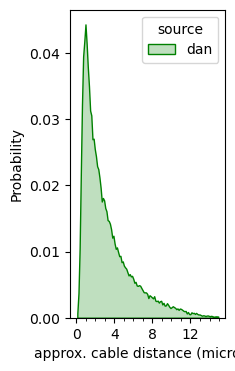

In [43]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


file = syndist_folder / 'kc_syn_distances.pkl'
with open(file, 'rb') as f:
    distances = pickle.load(f)
distances = np.concatenate([d['cable_distance']['dan_post']/1000*8 for d in distances])
distances = distances[~np.isnan(distances)]
print(distances.shape)
kc_df = pd.DataFrame({'cell': ['kc' for k in distances], 
                   'source': ['dan' for k in distances], 
                   'distances': distances})

kc_df.shape

fig, ax = plt.subplots(figsize=[2,4])

sns.histplot(data=kc_df, x='distances', hue='source',  fill=True,common_norm=False, ax=ax, cumulative=False,
             palette=('green', 'blue'),element='poly', stat='probability') #, cut=0,common_grid=True)

ax.set_xlabel('approx. cable distance (microns)')
ax.set_xticks([0,4,8,12])
ax.xaxis.set_minor_locator(AutoMinorLocator())

In [44]:
er_types = ('ER4d', 'ER2_a', 'ER2_b', 'ER2_c', 'ER2_d')
df = pd.DataFrame({'cell': [], 'source': [], 'distances': []})
for type in er_types[:1]:
    file = syndist_folder / f"{type}_syn_distances.pkl"
    with open(file, 'rb') as f:
        distances = pickle.load(f)

    el_dist, exr2_dist = [], []
    for nrn in distances:
        el_dist.append(nrn['cable_distance']['el_post'])
        exr2_dist.append(nrn['cable_distance']['exr2_post'])
    el_dist = np.concatenate(el_dist)
    # el_dist[np.isnan(el_dist)] = np.nanmax(el_dist + 10000/8)

    exr2_dist = np.concatenate(exr2_dist)
    # exr2_dist[np.isnan(exr2_dist)] = np.nanmax(exr2_dist+10000/8)
    names = ['el' for i in range(el_dist.shape[0])] + ['exr2' for i in range(exr2_dist.shape[0])]
    er = ['er' for i in range(len(names))]
    _df = pd.DataFrame({ 'cell': er,
                    'source': names,
                    'distances': np.concatenate((el_dist,exr2_dist))/1000*8})
    df = pd.concat((df,_df), ignore_index=False)


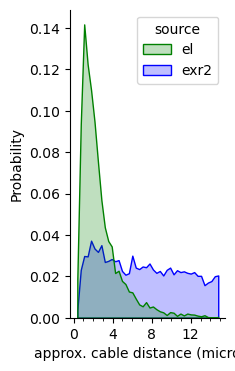

In [45]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

fig, ax = plt.subplots(figsize=[2,4])
sns.histplot(data=df, x='distances', hue='source',  fill=True,common_norm=False, ax=ax, cumulative=False,
            hue_order=('el', 'exr2'), palette=('green', 'blue'),element='poly', stat='probability') #, cut=0,common_grid=True)
# ax.set_xlim([0,10])
ax.set_xlabel('approx. cable distance (microns)')
ax.set_xticks([0,4,8,12])
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


In [46]:
comb_df = pd.concat((df, kc_df), ignore_index=True)


In [47]:
comb_df.head()

,cell,source,distances
0,er,el,0.898949
1,er,el,1.853679
2,er,el,2.006712
3,er,el,0.995447
4,er,el,2.229182


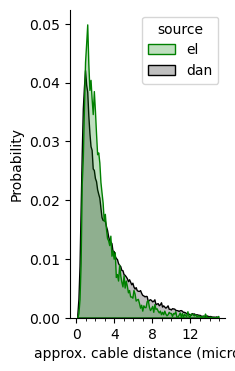

In [52]:
fig, ax = plt.subplots(figsize=[2,4])


sns.histplot(data=comb_df.loc[comb_df['source'].isin(['el', 'dan'])], x='distances', hue='source',  fill=True,common_norm=False, ax=ax, cumulative=False,
            hue_order=('el', 'dan'), palette=('green', 'black'),element='poly', stat='probability') #, cut=0,common_grid=True)
# ax.set_xlim([0,10])
ax.set_xlabel('approx. cable distance (microns)')
ax.set_xticks([0,4,8,12])
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig(figfolder / 'kc_v_er_syn_distances.pdf')
